<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Data_Augmentation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!touch stl10_input.py

In [0]:
!python stl10_input.py

In [0]:
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np

np.random.seed(0)

In [0]:
train_images = list(paths.list_images("train"))

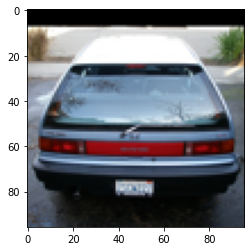

In [142]:
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]
image = plt.imread(sample_training_image)
plt.imshow(image)
plt.show()

In [0]:
# Reference: https://github.com/sthalles/SimCLR/blob/master/data_aug/gaussian_blur.py
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size=int(0.1 * 96), min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = sample.numpy()
        sample = sample.squeeze(0)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return tf.convert_to_tensor(np.expand_dims(sample, 0))

In [0]:
class CustomAugment(object):
	def __call__(self, sample):
		if np.random.random_sample() >= 0.5:
			h = np.random.choice(tf.shape(sample)[1].numpy(), 1) 
			w = np.random.choice(tf.shape(sample)[2].numpy(), 1)
			sample = tf.image.random_crop(sample, [1, int(h), int(w), 3])
			sample = tf.image.resize(sample, size=[96, 96])
		
		if np.random.random_sample() >= 0.5:
			sample = tf.image.flip_left_right(sample)
		
		if np.random.random_sample() >= 0.6:
			sample = self._color_jitter(sample)

		if np.random.random_sample() >= 0.2:
			sample = self._gray_scale(sample)

		return sample

	def _color_jitter(self, sample):
		sample = tf.image.random_brightness(sample, max_delta=0.5)
		sample = tf.image.random_contrast(sample, lower=0.01, upper=0.08)
		sample = tf.image.random_saturation(sample, lower=0.01, upper=0.08)
		sample = tf.image.random_hue(sample, max_delta=0.05)

		return sample

	def _gray_scale(self, sample):
		img2 = np.zeros_like(sample.numpy().squeeze(0))
		sample = tf.image.rgb_to_grayscale(sample)
		temp_sample = sample.numpy().squeeze()
		img2[:,:,0] = temp_sample
		img2[:,:,1] = temp_sample
		img2[:,:,2] = temp_sample

		new_sample = tf.convert_to_tensor(np.expand_dims(img2, 0))

		return new_sample

In [0]:
data_augmentation = keras.Sequential([
    layers.Lambda(CustomAugment()),
    layers.Lambda(GaussianBlur())
])

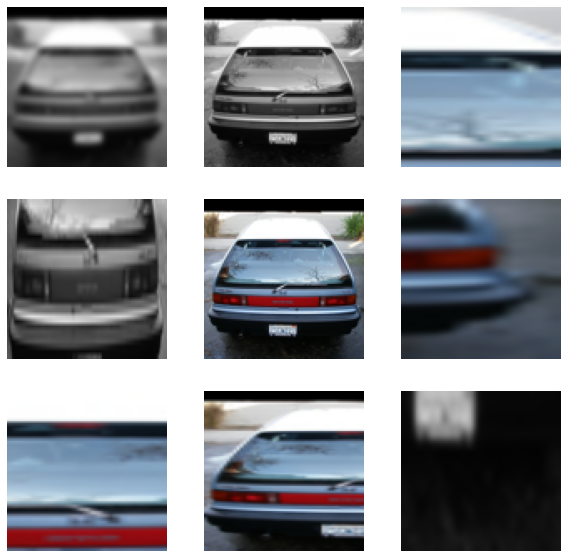

In [169]:
image = plt.imread(sample_training_image)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')